# Gridding a synthetic airborne survey

Let's perform a synthetic airborne survey of the synthetic model made out of prisms and try to interpolate the observed data on a regular grid.
Because the model is synthetic, we can compute the true value of the field on this regular grid. Therefore, we have an objective way to score the interpolation. This allow us to objectively compare the different source layouts.

Firstly, we want to import useful packages and define some minor functions that will help us to visualize better the notebook cells and reduce ammount of code on them.

**Table of Contents**

- [1. Define parameters used on the gridding](#1.-Define-parameters-used-on-the-gridding)
- [2. Create the synthetic airborne survey](#2.-Create-the-synthetic-airborne-survey)
- [3. Compute the field of the synthetic model on a grid](#3.-Compute-the-field-of-the-synthetic-model-on-a-grid)
- [4. Grid data with different source layouts and constant relative depth](#4.-Grid-data-with-different-source-layouts-and-constant-relative-depth)
    - [4.1. One source beneath each data point](#4.1.-One-source-beneath-each-data-point)
    - [4.2. Source beneath block reduced observation points](#4.2.-Source-beneath-block-reduced-observation-points)
    - [4.3. Regular grid of source points](#4.3.-Regular-grid-of-source-points)
- [5. Grid data with different source layouts and variable relative depth](#5.-Grid-data-with-different-source-layouts-and-variable-relative-depth)
    - [5.1. One source beneath each data point](#5.1.-One-source-beneath-each-data-point)
    - [5.2. Source beneath block reduced observation points](#5.2.-Source-beneath-block-reduced-observation-points)
- [6. Plot and compare the best predictions](#6.-Plot-and-compare-the-best-predictions)

**Import useful packages**

In [1]:
from IPython.display import display, HTML
import itertools
import pyproj
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

from eql_source_layouts import (
    synthetic_model,
    source_bellow_data,
    block_reduced_sources,
    grid_sources,
)

**Define functions to plot gridding results**

In [2]:
def plot_prediction(
    grid,
    prediction,
    target,
    title="Prediction",
    figsize=(12, 6),
    shrink_cbar=0.7,
):
    """
    Plot prediction and comparison with target
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=figsize)
    tmp = ax1.pcolormesh(*grid[:2], prediction)
    plt.colorbar(tmp, ax=ax1, shrink=shrink_cbar, label=field_units)
    ax1.set_aspect("equal")
    ax1.set_title(title)

    maxabs = vd.maxabs(target - prediction)
    tmp = ax2.pcolormesh(
        *grid[:2],
        target - best_prediction,
        vmin=-maxabs,
        vmax=maxabs,
        cmap="seismic",
    )
    plt.colorbar(tmp, ax=ax2, shrink=shrink_cbar, label=field_units)
    ax2.set_aspect("equal")
    ax2.set_title("Difference between target and prediction")
    plt.tight_layout()
    plt.show()
    
    
def histogram_errors(prediction, target, bins=20):
    """
    Plot histogram of prediction errors
    """
    plt.hist((target - prediction).ravel(), bins=bins)
    plt.title("Histogram of prediction errors")
    plt.show()

**Define function to print prediction parameters and scores with style**

In [3]:
def print_params_scores(parameters_sets, scores):
    """
    Display parameters and scores with style
    
    It also highlights the row that contains the maximum score
    """
    df = {}
    for keys in parameters_sets[0]:
        df[keys] = []
    df["score"] = []
    for parameters, score in zip(parameters_sets, scores):
        for key, param in parameters.items():
            df[key].append(param)
        df["score"].append(score)
    df = pd.DataFrame(df)
    display(df.style.apply(highlight_max_row, column="score", axis=None))
    return df


def highlight_max_row(df, column, color="orange"):
    """
    Highlight the row that contains the max value of a column
    """
    style = df.copy()
    is_max = (df[column] == df[column].max())
    background = [
        'background-color: {}'.format(color) if i else '' for i in is_max
    ]
    for col in style:
        style[col] = background
    return style

## 1. Define parameters used on the gridding

Let's define all the parameters that will be used on this notebook in the following cells. These control the results that will be obtain on the rest of the notebook. If you want to change something (like the computation height of the grid, the survey region, interpolation parameters, etc), you can just do it here.

We will avoid hardcoding parameters outside of these few cells in order to facilitate reproducibility and keep things more organized.

In [4]:
# Define a survey region of 1 x 1 degrees (~ 100km x 100km)
region_degrees = (-0.5, 0.5, -0.5, 0.5)

# Define bottom and top of the synthetic model
model_bottom, model_top = -10e3, 0

# Define which field will be meassured
field = "g_z"
field_units = "mGal"

# Define standard deviation for the Gaussian noise that
# will be added to the synthetic survey (in mGal)
noise_std = 0.5

# Define the spacing of the target regular grid
# and its observation height
grid_spacing = 2e3
grid_height = 2000

# Define set of interpolation parameters
# ======================================
# Define dampings used on every fitting of the gridder
dampings = [None, 1e-4, 1e-3, 1e-2]
# Define values of constant relative depth
relative_depths = [1e3, 2e3, 5e3, 10e3, 15e3]
# Define parameters for the grid layout:
#    spacing, relative depth and padding
source_grid_spacings = [0.5e3, 1e3, 2e3]
source_grid_relative_depths = [1e3, 2e3, 5e3]
source_grid_paddings = [0, 0.1, 0.2]
# Define parameters for variable relative depth layouts:
#    depth factor, depth shift and k_values
depth_factors = [0.5, 1, 5, 10]
depth_shifts = [-100, -1000, -5000]
k_values = [1, 10]
# We will set the block spacing for the block reduced
# layouts equal to the target grid spacing
block_spacing = grid_spacing

# Finally, define a dict where the best predictions will be
# stored to plot them altogether at the end of the notebook.
best_predictions = {"constant_depth": {}, "variable_depth": {}}

## 2. Create the synthetic airborne survey

To create the airborne survey we need to load the synthetic model made out of prisms, the location of the observation points and then compute the field that the prisms generate on those points.

Get coordinates of observation points

In [5]:
survey = hm.synthetic.airborne_survey(region=region_degrees)
display(survey)

,longitude,latitude,height
140691,-0.496429,0.497339,633.0
140692,-0.495559,0.497999,644.0
140693,-0.493218,0.497479,646.0
140694,-0.482725,0.497679,663.0
140695,-0.478464,0.497719,672.0
...,...,...,...
383610,-0.416257,0.155824,1070.0
383611,-0.258422,0.271476,1087.0
383612,-0.258652,0.277958,1126.0
383613,-0.258983,0.287360,1106.0


Project survey points into Cartesian coordinates

In [6]:
projection = pyproj.Proj(proj="merc", lat_ts=0)
survey["easting"], survey["northing"] = projection(
    survey.longitude.values, survey.latitude.values
)
display(survey)

# Define region boundaries in projected coordinates
region = (
    survey.easting.values.min(),
    survey.easting.values.max(),
    survey.northing.min(),
    survey.northing.max(),
)

,longitude,latitude,height,easting,northing
140691,-0.496429,0.497339,633.0,-55262.223508,54993.627800
140692,-0.495559,0.497999,644.0,-55165.348426,55066.630053
140693,-0.493218,0.497479,646.0,-54904.787861,55009.113126
140694,-0.482725,0.497679,663.0,-53736.719343,55031.235020
140695,-0.478464,0.497719,672.0,-53262.365493,55035.659399
...,...,...,...,...,...
383610,-0.416257,0.155824,1070.0,-46337.467390,17230.106636
383611,-0.258422,0.271476,1087.0,-28767.445331,30018.377395
383612,-0.258652,0.277958,1126.0,-28793.055985,30735.107734
383613,-0.258983,0.287360,1106.0,-28829.801706,31774.809862


Plot the survey points

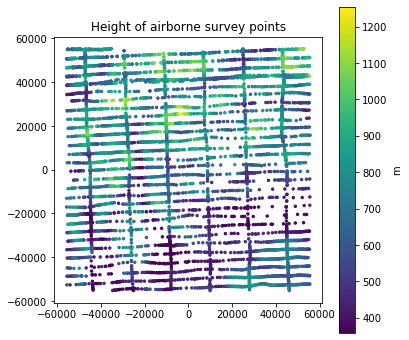

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of airborne survey points")
plt.show()

Get the synthetic model

In [8]:
# Define model region
model_region = tuple(list(region) + [model_bottom, model_top])

# Create synthetic model
model = synthetic_model(model_region)
print(model.keys())
print("Number of prisms: {}".format(len(model["densities"])))

dict_keys(['prisms', 'densities', 'rectangles'])
Number of prisms: 64


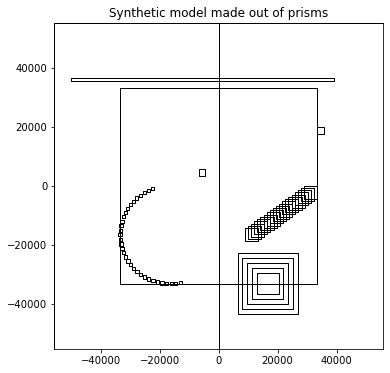

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_collection(PatchCollection(model["rectangles"], match_original=True))
ax.set_aspect("equal")
ax.set_title("Synthetic model made out of prisms")
ax.set_xlim(region[:2])
ax.set_ylim(region[2:4])
plt.show()

Compute the gravity field (g_z) on the observation points in mGal and add Gaussian noise

In [10]:
coordinates = (survey.easting, survey.northing, survey.height)
survey[field] = hm.prism_gravity(
    coordinates, model["prisms"], model["densities"], field=field
) + np.random.normal(scale=noise_std, size=survey.easting.size)
display(survey)

,longitude,latitude,height,easting,northing,g_z
140691,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.986828
140692,-0.495559,0.497999,644.0,-55165.348426,55066.630053,3.285713
140693,-0.493218,0.497479,646.0,-54904.787861,55009.113126,3.684822
140694,-0.482725,0.497679,663.0,-53736.719343,55031.235020,4.443360
140695,-0.478464,0.497719,672.0,-53262.365493,55035.659399,3.846099
...,...,...,...,...,...,...
383610,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,9.424978
383611,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.729357
383612,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,15.669790
383613,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,16.579835


Plot the observed field

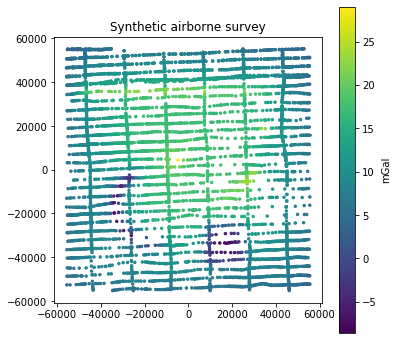

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=getattr(survey, field), s=6)
plt.colorbar(tmp, ax=ax, label=field_units)
ax.set_aspect("equal")
ax.set_title("Synthetic airborne survey")
plt.show()

## 3. Compute the field of the synthetic model on a grid

Now, let's compute the gravity field that the synthetic model generates on the regular grid. These results will serve as a target for the interpolations using different source layouts.

Build the regular grid

In [12]:
grid = vd.grid_coordinates(
    region=region, spacing=grid_spacing, extra_coords=grid_height
)

Compute the synthetic gravity field on the grid

In [13]:
target = hm.prism_gravity(
    grid, model["prisms"], model["densities"], field=field
)

Plot target gravity field

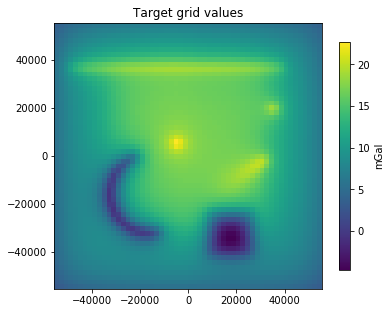

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.pcolormesh(*grid[:2], target)
plt.colorbar(tmp, ax=ax, shrink=0.7, label=field_units)
ax.set_aspect("equal")
ax.set_title("Target grid values")
plt.show()

## 4. Grid data with different source layouts and constant relative depth

Now, let's grid the synthetic data through different source layouts, but keeping the constant relative depth approach.
We will compare each interpolation with the target data in order to assess for the quality of each source layout.

Because the gridder could take several parameters that control the interpolation, we will perform several predictions with different set of parameters and then score each one of them against the target data. We will choose the best prediction as the one that produces the highest score. Because this score is computed agains *true data*, it's an objective quality estimator of the prediction.

### 4.1. One source beneath each data point

Let's perform several interpolations on the grid by setting a single source point beneath each data point at a constant relative depth. This can be achieved throught `harmonica.EQLHarmonic` by passing a points layout build through the `source_bellow_data()` function.
Each interpolation is performed with different values of the `damping` and `relative_depth` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [15]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1])
    for combo in itertools.product(dampings, relative_depths)
]

Perform the interpolations and score them against the target data

In [16]:
scores = []
for parameters in parameters_sets:
    # Create the source points layout by putting one source beneath
    # each data point
    points = source_bellow_data(coordinates, **parameters)
    # Initialize the gridder passing the points and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [17]:
df = print_params_scores(parameters_sets, scores)

,damping,relative_depth,score
0,nan,1000,-292.335
1,nan,2000,-156500
2,nan,5000,-3.70919e+07
3,nan,10000,-2.38595e+06
4,nan,15000,-101542
5,0.0001,1000,0.911919
6,0.0001,2000,0.897442
7,0.0001,5000,0.958066
8,0.0001,10000,0.978833
9,0.0001,15000,0.986018


Keep the best prediction and plot it

Best score: 0.9871357349605102
Best parameters: {'damping': 0.01, 'relative_depth': 10000.0}
Number of point sources: 5673


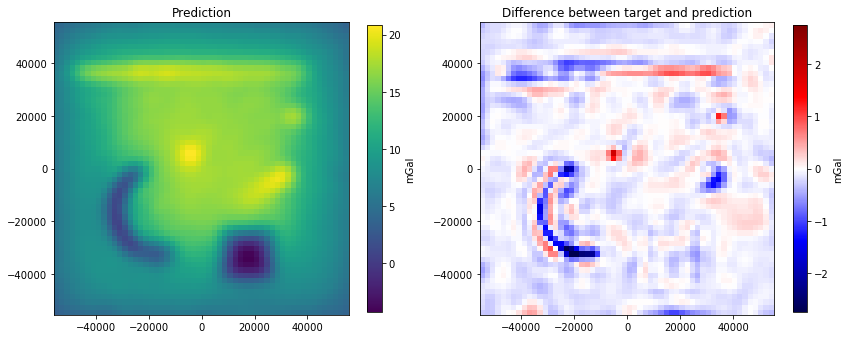

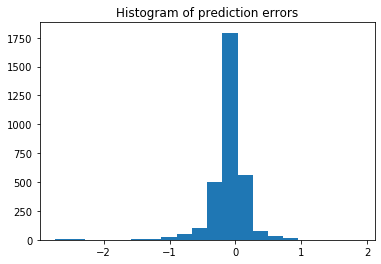

In [18]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = source_bellow_data(coordinates, **best_params)
eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

print("Number of point sources:", points[0].size)

# Store the best prediction
best_predictions["constant_depth"]["source_beneath_data"] = best_prediction

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### 4.2. Source beneath block reduced observation points

Now we will do the same, but with a different source layout: block reduce the observation points and put one source beneath each reduced coordinate at a constant relative depth.
For that we will need to make use of our `block_reduced_sources()` function.
Each interpolation will be performed with different values of the `damping` and `relative_depth` parameters. The `spacing` parameter will be set equal to the target grid spacing. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [19]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1], spacing=block_spacing)
    for combo in itertools.product(dampings, relative_depths)
]

Perform the interpolations and score them against the target data

In [20]:
scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by block reducing the
    # observed coordinates and setting the point sources at a constant
    # relative depth beneath them.
    points = block_reduced_sources(coordinates, **parameters)
    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [21]:
df = print_params_scores(parameters_sets, scores)

,damping,relative_depth,spacing,score
0,nan,1000,2000,0.935942
1,nan,2000,2000,0.955725
2,nan,5000,2000,0.973334
3,nan,10000,2000,-0.338425
4,nan,15000,2000,-29.2844
5,0.0001,1000,2000,0.935942
6,0.0001,2000,2000,0.955725
7,0.0001,5000,2000,0.975745
8,0.0001,10000,2000,0.984092
9,0.0001,15000,2000,0.987255


Keep the best prediction and plot it

Best score: 0.9872551389241832
Best parameters: {'damping': 0.0001, 'relative_depth': 15000.0, 'spacing': 2000.0}
Number of point sources: 1663


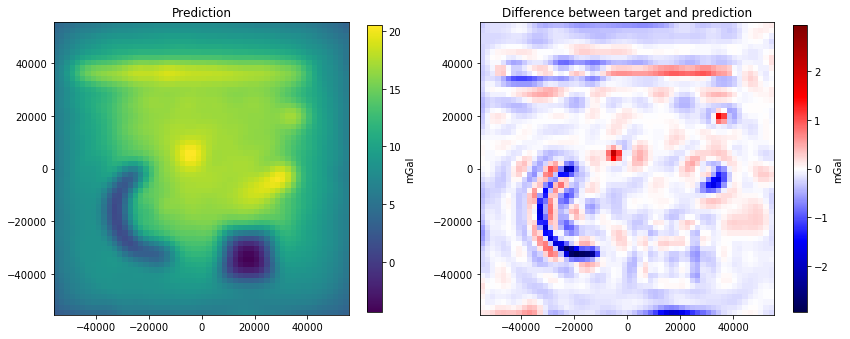

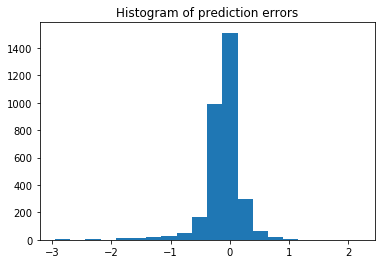

In [22]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = block_reduced_sources(coordinates, **best_params)
eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

print("Number of point sources:", points[0].size)

# Store the best prediction
best_predictions["constant_depth"]["block_reduced"] = best_prediction

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### 4.3. Regular grid of source points

Finally, let's build a regular grid of source points located at a relative constant depth beneath the mean height of observation points.
Each interpolation will be performed with different values of the `damping` and `relative_depth`. The `spacing` parameter will be set equal to the target grid spacing. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [23]:
parameters_sets = [
    dict(
        damping=combo[0], relative_depth=combo[1], pad=combo[2], spacing=combo[3]
    )
    for combo in itertools.product(
        dampings,
        source_grid_relative_depths,
        source_grid_paddings,
        source_grid_spacings,
    )
]

Perform the interpolations and score them against the target data. When fitting the gridder, it will raise a warning due to the fact that the determination of the coefficients for each source point is an under-determined problem: the number of point sources is bigger than the number of observation points.

In [24]:
# Compute mean height of observation points
mean_height = survey.height.mean()

scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by putting them on a
    # regular grid at a constant depth computed as the mean height
    # of observation points minus the relative depth.
    points = grid_sources(coordinates, **parameters)
    # Cancel fitting if too many points
    if points[0].size * coordinates[0].size > 1e8:
        print("Too many point sources")
        scores.append(np.nan)
        continue
    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 12544).
  jacobian.shape


Too many point sources
Too many point sources
Too many point sources
Too many point sources


/home/santi/.miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/verde/base/least_squares.py:42: UserWarning: Under-determined problem detected (ndata, nparams)=(5673, 6162).
  jacobian.shape


Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [25]:
df = print_params_scores(parameters_sets, scores)

,damping,relative_depth,pad,spacing,score
0,nan,1000,0,500,nan
1,nan,1000,0,1000,-1.01096e+19
2,nan,1000,0,2000,-5.41556e+13
3,nan,1000,0.1,500,nan
4,nan,1000,0.1,1000,nan
5,nan,1000,0.1,2000,-8.92896e+20
6,nan,1000,0.2,500,nan
7,nan,1000,0.2,1000,nan
8,nan,1000,0.2,2000,-2.35099e+20
9,nan,2000,0,500,nan


Keep the best prediction and plot it

Best score: 0.9528323598996333
Best parameters: {'damping': 0.01, 'relative_depth': 5000.0, 'pad': 0, 'spacing': 2000.0}
Number of point sources: 3192


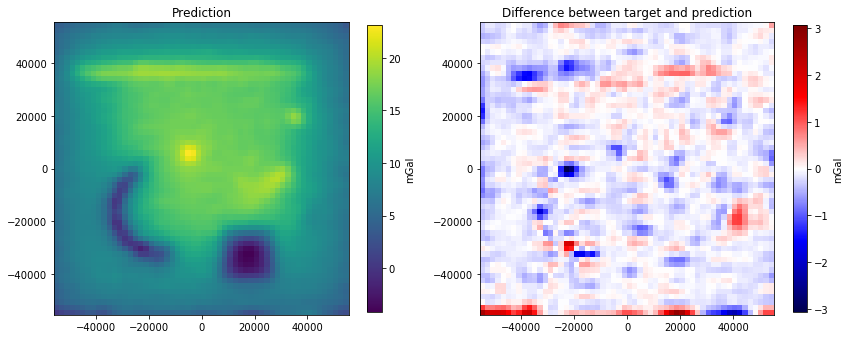

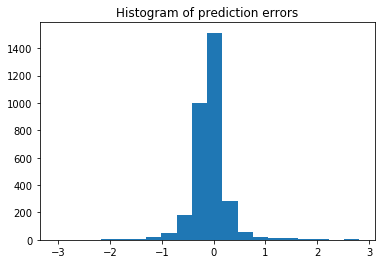

In [26]:
best = np.nanargmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = grid_sources(coordinates, **best_params)
eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

print("Number of point sources:", points[0].size)

# Store the best prediction
best_predictions["constant_depth"]["grid"] = best_prediction

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

## 5. Grid data with different source layouts and variable relative depth

We will perform the same steps as before, but now with variable relative depth.
For every source layout we will use our `variable_relative_depth()` function to compute the depth of each source point.

### 5.1. One source beneath each data point

Let's perform several interpolations on the grid by setting a single source point beneath each data point at a variable relative depth.
Each interpolation will be performed with different values of the `damping`, `depth_factor`, `depth_shift` and`k_nearest` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [27]:
parameters_sets = [
    dict(
        damping=combo[0],
        depth_factor=combo[1],
        depth_shift=combo[2],
        k_nearest=combo[3]
    )
    for combo in itertools.product(
        dampings, depth_factors, depth_shifts, k_values
    )
]

Perform the interpolations and score them against the target data

In [28]:
scores = []
for parameters in parameters_sets:
    # Create the source points layout by putting one source beneath
    # each data point. By leaving the relative_depth argument as None,
    # the function will use the variable relative depth approach.
    points = source_bellow_data(coordinates, **parameters)
    # Initialize the gridder passing the points and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [29]:
df = print_params_scores(parameters_sets, scores)

,damping,depth_factor,depth_shift,k_nearest,score
0,nan,0.5,-100,1,0.904251
1,nan,0.5,-100,10,-7.40539
2,nan,0.5,-1000,1,-119.965
3,nan,0.5,-1000,10,-2966.03
4,nan,0.5,-5000,1,-3.80709e+08
5,nan,0.5,-5000,10,-1.65628e+09
6,nan,1,-100,1,0.91562
7,nan,1,-100,10,-664.039
8,nan,1,-1000,1,-218.305
9,nan,1,-1000,10,-3.99941e+07


Keep the best prediction and plot it

Best score: 0.9813818246684097
Best parameters: {'damping': 0.01, 'depth_factor': 5, 'depth_shift': -5000, 'k_nearest': 10}
Number of point sources: 5673


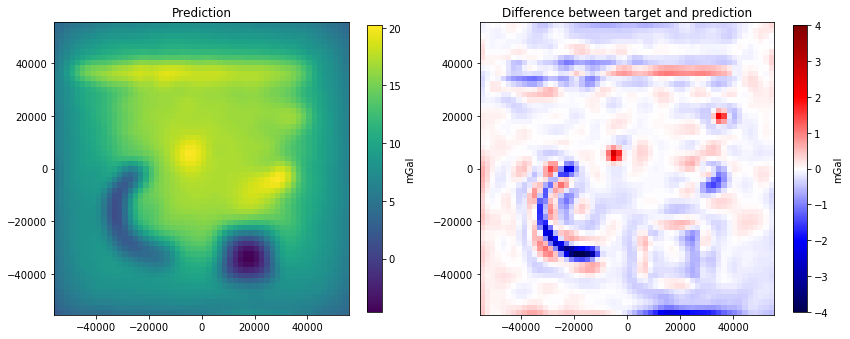

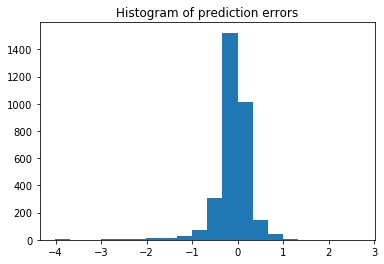

In [30]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = source_bellow_data(coordinates, **best_params)
eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

print("Number of point sources:", points[0].size)

# Store the best prediction
best_predictions["variable_depth"]["source_beneath_data"] = best_prediction

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### 5.2. Source beneath block reduced observation points

Now we will do the same, but with a different source layout: block reduce the observation points and put one source beneath each reduced coordinate at a variable relative depth.
For that we will need to make use of our `block_reduce_points()` function.
Each interpolation will be performed with different values of the `damping`, `depth_factor`, `depth_shift` and `k_nearest` parameters. The `spacing` parameter will be set equal to the target grid spacing. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [31]:
parameters_sets = [
    dict(
        damping=combo[0],
        spacing=block_spacing,
        depth_factor=combo[1],
        depth_shift=combo[2],
        k_nearest=combo[3],
    )
    for combo in itertools.product(
        dampings, depth_factors, depth_shifts, k_values
    )
]

Perform the interpolations and score them against the target data

In [32]:
scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by block reducing the
    # observed coordinates and setting the point sources at a constant
    # relative depth beneath them. By leaving the relative_depth argument as None,
    # the function will use the variable relative depth approach.
    points = block_reduced_sources(coordinates, **parameters)
    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [33]:
df = print_params_scores(parameters_sets, scores)

,damping,spacing,depth_factor,depth_shift,k_nearest,score
0,nan,2000,0.5,-100,1,0.941354
1,nan,2000,0.5,-100,10,0.962693
2,nan,2000,0.5,-1000,1,0.957132
3,nan,2000,0.5,-1000,10,0.969311
4,nan,2000,0.5,-5000,1,0.973116
5,nan,2000,0.5,-5000,10,0.916914
6,nan,2000,1,-100,1,0.959871
7,nan,2000,1,-100,10,0.974422
8,nan,2000,1,-1000,1,0.968156
9,nan,2000,1,-1000,10,0.969623


Keep the best prediction and plot it

Best score: 0.9893638297190663
Best parameters: {'damping': 0.01, 'spacing': 2000.0, 'depth_factor': 1, 'depth_shift': -5000, 'k_nearest': 10}
Number of point sources: 1663


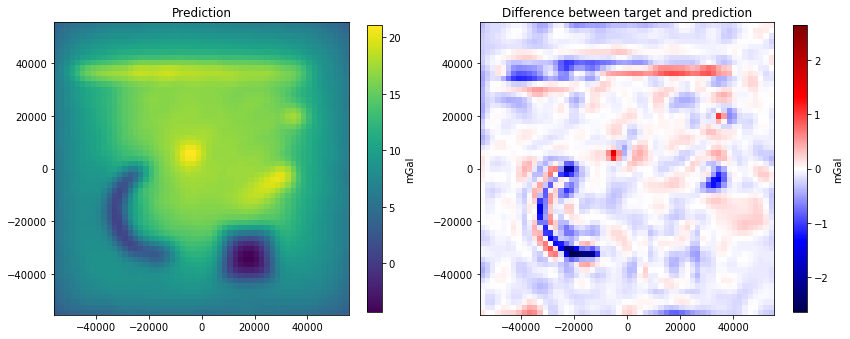

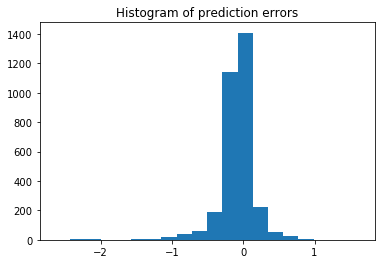

In [34]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = block_reduced_sources(coordinates, **best_params)
eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

print("Number of point sources:", points[0].size)

# Store the best prediction
best_predictions["variable_depth"]["block_reduced"] = best_prediction

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

## 6. Plot and compare the best predictions

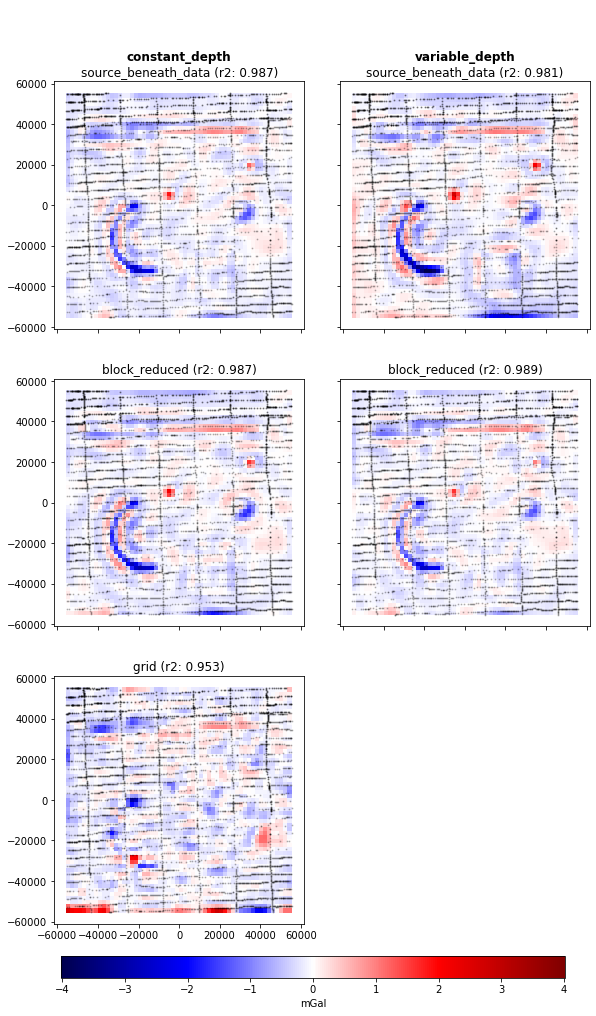

In [35]:
# Get max absolute value of the difference between target an all predictions
# in order to plot every difference with the same color scale.
maxabs = vd.maxabs(
    tuple(
        target - i
        for subset in best_predictions.values()
        for i in subset.values()
    )
)

# Initialize figure
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(10, 15),
    sharex=True,
    sharey=True,
)

# Plot the differences between the target and the best prediction for each layout
axes = axes.T
for ax_col, relative_depth in zip(axes, best_predictions):
    for ax, layout in zip(ax_col, best_predictions[relative_depth]):
        prediction = best_predictions[relative_depth][layout]
        tmp = ax.pcolormesh(
            *grid[:2],
            target - prediction,
            vmin=-maxabs,
            vmax=maxabs,
            cmap="seismic",
        )
        ax.scatter(survey.easting, survey.northing, s=1, alpha=0.2, color="k")
        ax.set_aspect("equal")
        ax.set_title("{} (r2: {:.3f})".format(layout, r2_score(target, prediction)))      

# Hide the last axe because it's not used
axes[-1][-1].set_visible(False)        

# Annotate the rows of the figure
for i in range(2):
    axes[i][0].annotate(
        list(best_predictions.keys())[i],
        xy=(0.04 + abs(i - 0.26), 0.94),
        xycoords="figure fraction",
        fontsize="large",
        horizontalalignment="center",
        fontweight="bold",
    )

# Add colorbar
fig.subplots_adjust(bottom=0.1, wspace=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label=field_units)

plt.show()